# Libraries and Dependencies

In [2]:
"""
Pre-requisites for the notebook 
"""
from torchmetrics import PearsonCorrCoef
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score
import torch
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### One-Hot-Vector Codification

In [3]:
"""
This is the formatted code for the one-hot-vector encoding of the data. 
Only necessary code was included. Taken from the base code provided.
"""

# Read data frame
df = pd.read_csv('UNSW_NB15_training-set.csv')

# Drop the id and attack category, not used 
def basic_pre_processing():
    list_drop = ['id', 'attack_cat']
    df.drop(list_drop, axis=1, inplace=True)

# Reduce the cardinality to reduce one hot encoded features dimensionality
def codification_cat_data():
    X = df.iloc[:, :-1]
    X.head()
    df_cat = df.select_dtypes(exclude=[np.number])
    DEBUG = 0
    for feature in df_cat.columns:
        if DEBUG == 1:
            print(feature)
            print('nunique = ' + str(df_cat[feature].nunique()))
            print("Is the cardinality higher than 6? ", df_cat[feature].nunique() > 6)
            print("Number of preserved records: ", sum(df[feature].isin(df[feature].value_counts().head().index)))
            print("New categories: (- takes the rest of categories)", df[feature].value_counts().head().index)
            print('----------------------------------------------------')
        if df_cat[feature].nunique() > 6:
            df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')

# Call previous functions to apply the codification
def perform_codification():
    basic_pre_processing()
    codification_cat_data()
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3])], remainder='passthrough')
    X = np.array(ct.fit_transform(X))
    return X, y

# Point 1 from TP

1. (10 puntos) Particione los datos en 80% datos de entrenamiento y el restante 20% en datos de prueba. Para ese 20% de datos de prueba, reporte la tasa de aciertos y el F1-score para la clase ataque, para 30 corridas, usando todos los atributos del dataset. Como clasificador, implemente por su cuenta el algoritmo de minimos cuadrados. Los atributos categoricos deben ser representados usando la codificacion one-hot-vector. 

In [4]:
X, y = perform_codification()

def split_dataset(data, tags, test_size=0.20, random_state=None):
    """
    Function to partition the dataset.
    Default 80% train and 20% test.
    :returns: x_train, x_test, y_train, y_test
    """
    # Uses the function from scikit learn
    x_train, x_test, y_train, y_test = train_test_split(data, tags, test_size=test_size, random_state=random_state)
    return x_train, x_test, y_train, y_test


def get_optimum_w_square_means(t, x):
    """
    Function to obtain the optimal w for t (tags) and x (data).
    :returns: optimal w
    """
    # Applies the formula explained during class, to calculate w using vectors.
    m_pinv = torch.pinverse(x)
    w_opt = m_pinv.mm(t)
    return w_opt


def evaluate_model_original(data, w, activation_function=False):
    """
    Function to evaluate the model.
    It consists of the dot product between the data and the optimum w.
    If the result is greater than zero then the class is 1. Otherwise, the class is 0.
    :returns: the estimated tags.
    """
    # Applies the activation function
    y_out = data.mm(w)    
    if activation_function:
        y_out[y_out >= 0] = 1
        y_out[y_out < 0] = 0
    t_estimated = y_out
    return t_estimated


def evaluate_mean_square_error(t, t_estimated):
    """
    Calculates the mean squared error for the tags and the estimated tags of the model.
    :return: mean squared error
    """
    # Using the MSE formula we calculate the error
    error = torch.norm(t - t_estimated, 2) / (2 * t.shape[0])
    return error

### 30 Runs

In [5]:
def run_30():
    """
    Partitions the data, calculates the optimum w, and returns the error, accuracy, and f1 scores.
    It performs this process 30 times.
    :return: a log of the results.
    """
    # Dictionary variable to save the results
    log = {}
    for i in range(30):
        x_train, x_test, y_train, y_test = split_dataset(X, y)

        # Training model
        train = torch.tensor(x_train)
        targets = torch.tensor(y_train.to_numpy()).unsqueeze(1).to(torch.float64)
        w_opt = get_optimum_w_square_means(targets, train)

        # Testing model
        test = torch.tensor(x_test)
        test_targets = torch.tensor(y_test.to_numpy()).unsqueeze(1).to(torch.float64)
        targets_estimated = evaluate_model_original(test, w_opt, activation_function=True)

        # Calculating error, accuracy and f1 score
        error = evaluate_mean_square_error(test_targets, targets_estimated)
        accuracy = accuracy_score(test_targets, targets_estimated)
        f1s = f1_score(test_targets, targets_estimated, average='weighted')

        # Saving results in the log
        log[f"Run #{i}"] = {'error': round(error.item(), 4), 'accuracy': accuracy, 'f1s': f1s}
    return log

# Calling the functions to get the results
log = run_30()
log_data_frame = pd.DataFrame.from_dict(log)
pd.DataFrame.transpose(log_data_frame)

,error,accuracy,f1s
Run #0,0.0022,0.671525,0.614719
Run #1,0.0023,0.664541,0.604048
Run #2,0.0022,0.669339,0.612458
Run #3,0.0022,0.672011,0.615483
Run #4,0.0022,0.672314,0.615476
Run #5,0.0022,0.670857,0.612944
Run #6,0.0022,0.668792,0.608859
Run #7,0.0022,0.669582,0.611837
Run #8,0.0022,0.667638,0.609234
Run #9,0.0022,0.668914,0.609881


# Point 2 from TP

2. (30 puntos) Implemente la funcion calculate_expected_calibration_error(X, y, uncertainties), el cual tome como entrada un conjunto de observaciones junto con sus etiquetas correctas (ground truth) y sus cuantificaciones de incertidumbre, y calcule el expected calibration error (ECE) según lo explicado en el material de apoyo.

    \
    a) Diseñe y documente los resultados de al menos dos pruebas unitarias.  

### ECE calculate_expected_calibration_error

In [6]:
def calculate_expected_calibration_error(x_in, y_real, uncertainties, y_predicted, n_bins=10, plot=True):
    """
    Calculates ECE by comparing bin average uncertainties with bin accuracies using Pearson coefficient.
    Uses n_bins for grouping uncertainties, default is 10. Can optionally plot the accuracy chart.
    :return: normalized ECE value between 0 and 1
    """
    # Calculate bins ranges
    bins = create_bins_and_append_prediction_to_values(uncertainties, y_real, y_predicted, n_bins)
    # Calculate the accuracy of each bin
    accuracy_bins = torch.tensor([calculate_accuracy_bin(bins[bin_num]) for bin_num in bins])

    # Calculate the average uncertainty of each bin
    bin_average_uncertainty = [sum(data[0] for data in bins[in_bin]) / len(bins[in_bin]) for in_bin in bins]
    bin_average_uncertainty = torch.tensor(bin_average_uncertainty)

    # Pearson coefficient calculation
    pearson = PearsonCorrCoef()
    pearson_corr = pearson(bin_average_uncertainty, accuracy_bins).nan_to_num().item()
    
    # Plotting: bin_average_uncertainty -> Acts as X | accuracy_bins -> Acts as Y
    if plot:
        plot_bin_accuracy_chart(bins, accuracy_bins, bin_average_uncertainty)

    # Convert pearson coefficient into 0-1 range, where values near 0 represents high calibration 
    ece = 1 - abs(pearson_corr)
    return max(0, min(ece, 1))


def create_bins_and_append_prediction_to_values(uncertainties, y_real, y_predicted, n_bins):
    """
    Groups predictions into bins based on uncertainty quantiles.
    Maps each prediction to a bin for subsequent accuracy and uncertainty calculations.
    Also checks if predictions match real labels.
    :return: Dictionary of bins with each bin containing tuples of (uncertainty, prediction match).
    """
    # Convert uncertainties to torch tensor for quantile calculations
    uncertainties_np = torch.tensor(uncertainties).to(torch.float64)

    # Calculate quantiles to define bin edges
    quantiles = torch.linspace(0, 1, n_bins + 1).to(torch.float64)
    bin_edges = torch.quantile(uncertainties_np, quantiles)

    # Create bins
    bins = {i: [] for i in range(n_bins)}

    # Assign values to bins
    for uncertainty, real_label, predicted_label in zip(uncertainties, y_real, y_predicted):
        # Determine the bin index by finding the first bin edge that is greater than the uncertainty
        index = torch.searchsorted(bin_edges, uncertainty, right=True) - 1
        index = min(index.item(), n_bins - 1)  # Ensure the value equal to max_val is included in the last bin
        prediction = (predicted_label >= 0).to(torch.float64) == real_label
        bins[index].append((uncertainty, prediction))

    return bins


def calculate_accuracy_bin(in_bin):
    """
    Calculates the percentage accuracy for a bin of predictions.
    If the bin is empty, returns 0.
    :return: Accuracy as a percentage of correct predictions in the bin.
    """
    # Check if the bin is empty
    if len(in_bin) == 0:
        return 0
    
    # Calculate the number of correct predictions inside the bin
    correct_predictions = 0
    for value in in_bin:
        correct_predictions += 1 if value[1] else 0
    
    # Get the accuracy percentage using the total bin size
    total_predictions = len(in_bin)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy


def plot_bin_accuracy_chart(bins, accuracy_bins, bin_average_uncertainty):
    """
    Plots a chart showing the accuracy per bin along with the average uncertainty.
    Visualizes each bin's accuracy with red dots and dashed lines for bin edges.
    Enhances the x-axis with custom tick labels showing bin numbers and average uncertainty.
    :return: None; displays the plot directly.
    """
    bin_edges_visual = torch.linspace(min(bins[0])[0].item(), max(bins[len(bins) - 1])[0].item(), steps=len(bins) + 1)
    bin_centers_visual = 0.5 * (bin_edges_visual[:-1] + bin_edges_visual[1:])

    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot a dot in the middle of each bin.
    for center, value in zip(bin_centers_visual, accuracy_bins):
        ax.plot(center, value, 'ro')  # 'ro' for red circle

    # Print average uncertainty for each bin in x-axis.
    custom_ticks = [center for center in bin_centers_visual]
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels([f"#{bin_num + 1}" for bin_num in range(len(bin_average_uncertainty))])

    # Add a line for each bin edge
    for edge in bin_edges_visual:
        ax.axvline(edge, color='red', linestyle='dashed', linewidth=1)

    # Set axis labels and title.
    ax.set_xlabel('')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy per Bin for ECE calculation')

    # Set y-axis limits to fit the range of bin values.
    ax.set_ylim(-10, 110)

    # Print bin number in secondary x-axis.
    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 17))
    ax2.set_xlabel('Bin Number and Average Uncertainty (Variance)')
    ax2.set_xticks(custom_ticks)
    custom_labels = [f"{"{:.1e}".format(round(bin_num.item(), 5))}" for index, bin_num in
                     enumerate(bin_average_uncertainty)]
    ax2.set_xticklabels(custom_labels)
    ax2.set_xlim(ax.get_xlim())
    ax2.spines['bottom'].set_visible(False)

    plt.show()

### Unit Tests

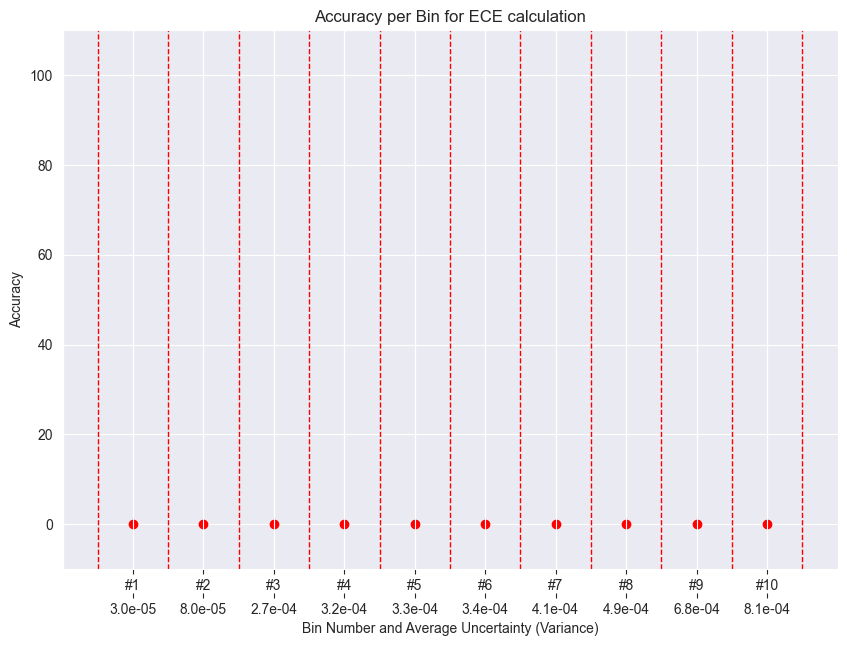

Worse Calibration Test:
Result: Passed! 
Calculated ECE: 1.0 
Expected: 1.0


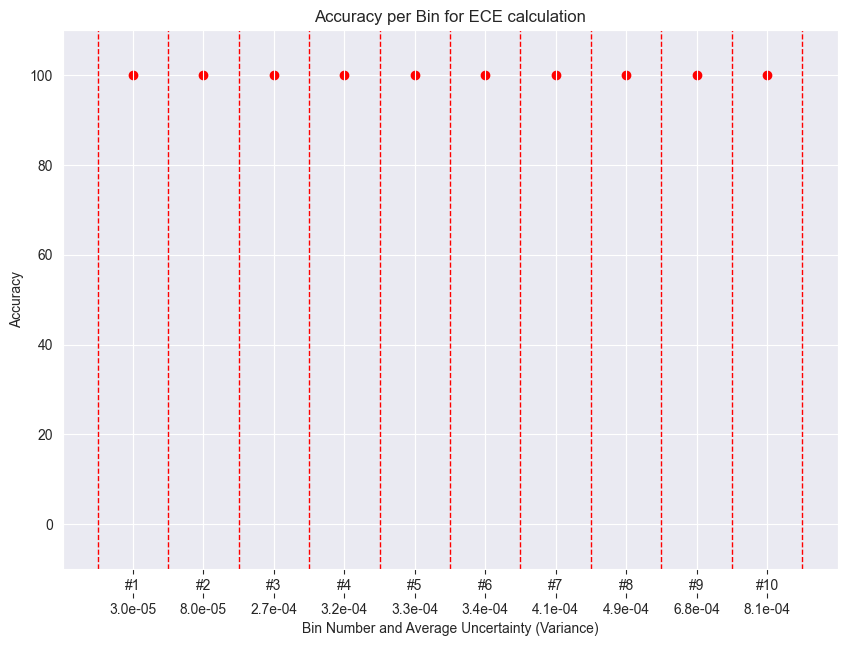

Perfect Calibration Test:
Result Passed! 
Calculated ECE: 0 
Expected: 0


In [7]:
def test_calculate_expected_calibration_error_worse_calibration():
    """
    Tests the calculate_expected_calibration_error function to ensure it returns an ECE of 1,
    indicating maximum miscalibration, under predefined worse calibration conditions.
    Asserts the correctness of the ECE calculation.
    :return: Prints success message with calculated ECE and expected value.
    """
    # Using an example previously checked, the values for scores and y_estimated were retrieved for this test
    example_variances = torch.tensor([0.000814, 0.000343, 0.000491, 0.000273, 0.000321, 0.000325, 0.000034, 0.000678, 0.000084, 0.00041])
    example_y_outputs = torch.tensor([0.871897, -0.095776, -0.199759, 1.157389, 0.4576, 0.455021, 0.95016, 0.559645, 0.901524, 0.493699])
    example_y_real = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
    
    # The ece is evaluated using the values of a not calibrated scenario
    ece = calculate_expected_calibration_error(None, example_y_real, example_variances, example_y_outputs, plot=True)
    assert ece == 1
    print("Worse Calibration Test:")
    print(f"Result: Passed! \nCalculated ECE: {ece} \nExpected: 1.0")


def test_calculate_expected_calibration_error_perfect_calibration():
    """
    Tests the calculate_expected_calibration_error function to ensure it returns an ECE of 0,
    indicating perfect calibration, under predefined perfect calibration conditions.
    Asserts the correctness of the ECE calculation.
    :return: Prints success message with calculated ECE and expected value.
    """
    # Using an example previously checked, the values for scores and y_estimated were retrieved for this test
    example_variances = torch.tensor([0.000814, 0.000343, 0.000491, 0.000273, 0.000321, 0.000325, 0.000034, 0.000678, 0.000084, 0.00041])
    example_y_outputs = torch.tensor([0.871897, -0.095776, -0.199759, 1.157389, -0.4576, -0.455021, 0.95016, 0.559645, 0.901524, 0.493699])
    example_y_real = [1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
    
    # The ece is evaluated using the values of a fully calibrated scenario
    ece = calculate_expected_calibration_error(None, example_y_real, example_variances, example_y_outputs, plot=True)
    assert ece == 0
    print("Perfect Calibration Test:")
    print(f"Result Passed! \nCalculated ECE: {ece} \nExpected: 0")
    
test_calculate_expected_calibration_error_worse_calibration()
print("\n")
test_calculate_expected_calibration_error_perfect_calibration()

# Point 3 from TP

3. (30 puntos) Implemente el algoritmo de estimacion de incertidumbre de ensamble detallado en el material de apoyo. Para ello, hagalo en la funcion quantify_uncertainty_ensemble(x, model, N = 10) el cual cuantifique la incertidumbre para una entrada $\overrightarrow{x}\in\mathbb{R}^{D}$, y retorne tal resultado. Hagalo usando modelos de minimos cuadrados de clasificacion. Utilice la salida del producto punto (sin pasar por la funcion de activacion del modelo), para obtener los puntajes de los miembros del ensamble. Se recomienda dividir la implementacion de esta funcion en la funcion train_ensemble la cual entrene los miembros del ensamble, y run_ensemble_uq la cual tome el ensamble anteriormente construido y evalue la varianza de las salidas. 
    \
    a) Diseñe y documente los resultados de al menos dos pruebas unitarias.

###  Uncertainty Ensemble quantify_uncertainty_ensemble

In [8]:
def quantify_uncertainty_ensemble(x_test, model, n_ensemble=10, ensemble=None, random_state=None):
    """
    Generates ensemble predictions and calculates the variance and mean prediction for each test sample.
    Uses an ensemble of models to quantify uncertainty in predictions.
    :return: Tensors of variances and mean predictions.
    """
    # If no ensemble is provided, build one
    if ensemble is None:
        ensemble = train_ensemble(n_ensemble, random_state=random_state)
    # T estimated outputs from the ensemble
    y_outputs = run_ensemble_uq(x_test, ensemble, model)
    # Passing entries to X axis and ensemble weights to Y axis
    # Each cell shows the estimated output per ensemble weight
    y_outputs_stacked = torch.stack(y_outputs).squeeze(-1).t()
    variances = []
    predictions = []
    # Each y_out represents the estimated output among all ensemble weights
    for y_out in y_outputs_stacked:
        # Uncertainty calculated utilizing the variance
        var_xi = torch.var(y_out)
        # Prediction calculated with the average of the predictions per weight 
        predicted_y = torch.mean(y_out)
        variances.append(var_xi)
        predictions.append(predicted_y)
    return torch.tensor(variances), torch.tensor(predictions)


def train_ensemble(n, x_train=None, y_train=None, random_state=None):
    """
    Trains an ensemble of models using K-fold training subsets.
    Handles data splitting if training data is not provided.
    :return: List of trained ensemble weights.
    """
    # In case no training data is provided, create new training data with 70% train and 30% test 
    if x_train is None or y_train is None:
        x_train, _, y_train, _ = split_dataset(X, y, test_size=0.3, random_state=random_state)
    # Obtaining the training data splits to train the weights for the ensemble          
    train_splits = kfold_split(x_train, y_train.to_numpy(), n, random_state=random_state)
    weights = []
    for split in train_splits:
        x_split = torch.tensor(split[0])
        y_split = torch.tensor(split[1]).unsqueeze(1).to(torch.float64)
        # Running the training function 
        w_opt = get_optimum_w_square_means(y_split, x_split)
        weights.append(w_opt)
    return weights


def kfold_split(features, labels, n_splits, random_state=None):
    """
    Splits the dataset into training and testing subsets using K-fold cross-validation.
    :return: List of tuples containing feature subsets and corresponding labels for each fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)  # Using a random state for reproducibility
    # This will store the training subsets and their corresponding labels
    subsets = []
    
    # Building subsets with kf.split
    for train_index, test_index in kf.split(features):
        feature_subset = features[test_index]
        label_subset = labels[test_index]
        subsets.append((feature_subset, label_subset))

    return subsets


def run_ensemble_uq(x, ensemble, model):
    """
    Generates ensemble predictions by running the model with each ensemble member on input x.
    :return: List of outputs from each ensemble model.
    """
    # Running Forward function for each weight in ensemble 
    y_outputs = [model(x, indv_weight) for indv_weight in ensemble]
    return y_outputs

### Unit Tests

In [9]:
def test_quantify_uncertainty_ensemble_individual_entry():
    """
    Tests the quantify_uncertainty_ensemble function for a single test entry.
    Ensures the calculated variance and output matches expected values for a consistent dataset.
    :return: Prints results and asserts the correct computation of variance and output.
    """
    # Splitting dataset with random state 42 to ensure reproducibility
    x_train, x_test, y_train, y_test = split_dataset(X, y, random_state=42)
    # Individual entry
    entry = torch.tensor(x_test[0]).unsqueeze(-1).t().to(torch.float64)
    # Passing entry to the ensemble 
    variance, y_outputs = quantify_uncertainty_ensemble(entry, evaluate_model_original, n_ensemble=10, random_state=42)
    # Rounding the outputs for visibility
    variance = round(variance.item(), 3)
    y_outputs = round(y_outputs.item(), 3)
    assert variance == 0.002
    assert y_outputs == 0.011
    print("Single Entry Test:")
    print(f"Result: Passed! \nCalculated Variance: {variance} \nExpected: {0.002}")
    print(f"Estimated Output: {y_outputs} \nExpected: {0.011}")


def test_quantify_uncertainty_ensemble_multiple_entry():
    """
    Tests the quantify_uncertainty_ensemble function for multiple test entries.
    Ensures the calculated variance and outputs match expected values for a set of consistent test data.
    :return: Prints results and asserts the correct computation for an array of variances and outputs.
    """
    # Splitting dataset with random state 42 to ensure reproducibility
    x_train, x_test, y_train, y_test = split_dataset(X, y, random_state=42)   
    x_test = torch.tensor(x_test)
    # Gathering multiple entries and stacking them into a tensor
    entries = torch.stack([x_test[0], x_test[1], x_test[2]])
    variance, y_outputs = quantify_uncertainty_ensemble(entries, evaluate_model_original, n_ensemble=10, random_state=42)
    # Rounding the outputs for visibility
    variance = [round(x, 4) for x in list(variance.numpy())]
    y_outputs = [round(x, 4) for x in list(y_outputs.numpy())]
    assert variance == [0.0024, 0.0001, 0.0004]
    assert y_outputs == [0.0108, 0.9777, 0.8247]
    print("Multiple Entry Test:")
    print(f"Result: Passed! \nCalculated Variance: {variance} \nExpected: [0.0024, 0.0001, 0.0004]")
    print(f"Estimated Outputs: {y_outputs} \nExpected: [0.0108, 0.9777, 0.8247]")
    
test_quantify_uncertainty_ensemble_individual_entry()
print("\n")
test_quantify_uncertainty_ensemble_multiple_entry()

Single Entry Test:
Result: Passed! 
Calculated Variance: 0.002 
Expected: 0.002
Estimated Output: 0.011 
Expected: 0.011


Multiple Entry Test:
Result: Passed! 
Calculated Variance: [0.0024, 0.0001, 0.0004] 
Expected: [0.0024, 0.0001, 0.0004]
Estimated Outputs: [0.0108, 0.9777, 0.8247] 
Expected: [0.0108, 0.9777, 0.8247]


# Point 4 from TP

4. (30 puntos) Documente las siguientes pruebas: mida el ECE y el tiempo de ejecucion usando la funcion anterior, y un conjunto de datos de prueba correspondiente al 30% de los datos provistos. El 70% de los datos restantes se usaran para entrenar el o los modelos necesarios. Realice lo anterior para las siguientes configuraciones:
\
    a) N=10. 
\
    b) N=100
\
    c) N=1000
\
    Realice 10 particiones de test/training para calcular el ECE promedio por cada configuracion. Reporte el ECE promedio, y desviacion estandar de cada configuracion probada. Grafique los resultados de forma ordenada y clara, y comentelos. 

In [84]:
def run_tests(n):
    """
    Executes multiple testing cycles on ensemble models to measure calibration error.
    Runs tests across 10 different dataset splits to calculate and analyze ECE.
    Calculates average ECE, its standard deviation, and logs each test's results.
    :return: A dictionary with overall results including elapsed time and ECE statistics,
             and a dictionary with ECE results per iteration.
    """      
    # List to save ECE scores per iteration (partition)
    calculated_ece_list = []
    
    start_time = time.time()
    for i in range(10):
        # Splitting using random_state to ensure reproducibility
        x_train, x_test, y_train, y_test = split_dataset(X, y, test_size=0.30, random_state=42+i)
        # Training ensemble
        trained_ensemble = train_ensemble(n, x_train, y_train, random_state=42+i)
        x_test = torch.tensor(x_test)
        variance, y_outputs = quantify_uncertainty_ensemble(x_test, evaluate_model_original, ensemble=trained_ensemble)        
        ece = calculate_expected_calibration_error(x_test, y_train, variance, y_outputs, plot=False)
        calculated_ece_list.append(ece)
    
    # Calculate average ECE and STD from calculated_ece_list
    calculated_ece_list = torch.tensor(calculated_ece_list)
    avg_ece = torch.mean(calculated_ece_list)
    std = torch.std(calculated_ece_list)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Preparing Results to display
    results = {f"N={n}": {"Elapsed time": elapsed_time,
                          "Average ECE": round(avg_ece.item(), 4),
                          "Standard Deviation": round(std.item(), 4)}}
    
    results_per_iteration = {f"Iteration #{index + 1}": round(data.item(), 4) for index, data in enumerate(calculated_ece_list)}
            
    plot_results(calculated_ece_list, avg_ece, std, n)    
    return results, results_per_iteration


def plot_results(test_partition_ece, average_ece, std, n_configuration):
    """
    Plots ECE values across different partitions, highlighting the average ECE and standard deviation.
    Visualizes calibration performance for a given ensemble configuration.
    :return: None; displays a plot.
    """
    x_linspace = torch.linspace(0, len(test_partition_ece), steps=len(test_partition_ece) + 1)
    y_centers = 0.5 * (x_linspace[:-1] + x_linspace[1:])

    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot a dot in the middle.
    for center, value in zip(y_centers, test_partition_ece):
        ax.plot(center, value, 'ro')  # 'ro' for red circle

    # Print labels.
    custom_ticks = [center for center in y_centers]
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels([f"#{bin_num + 1}" for bin_num in range(len(test_partition_ece))])

    # Add a line for each partition.
    for edge in x_linspace:
        ax.axvline(edge, color='red', linestyle='dashed', linewidth=1)

    # Adding Labels to Chart 
    ax.set_xlabel('Partition number (iteration)')
    ax.set_ylabel('ECE')
    ax.set_ylim(0, 1)
    ax.set_title(f'Partitions ECE values | Configuration N={n_configuration}'
                 f' \n Average ECE: {round(average_ece.item(), 4)} '
                 f'| Standard Deviation: {round(std.item(), 4)}')

    plt.show()

# Testing configurations
### Testing N = 10

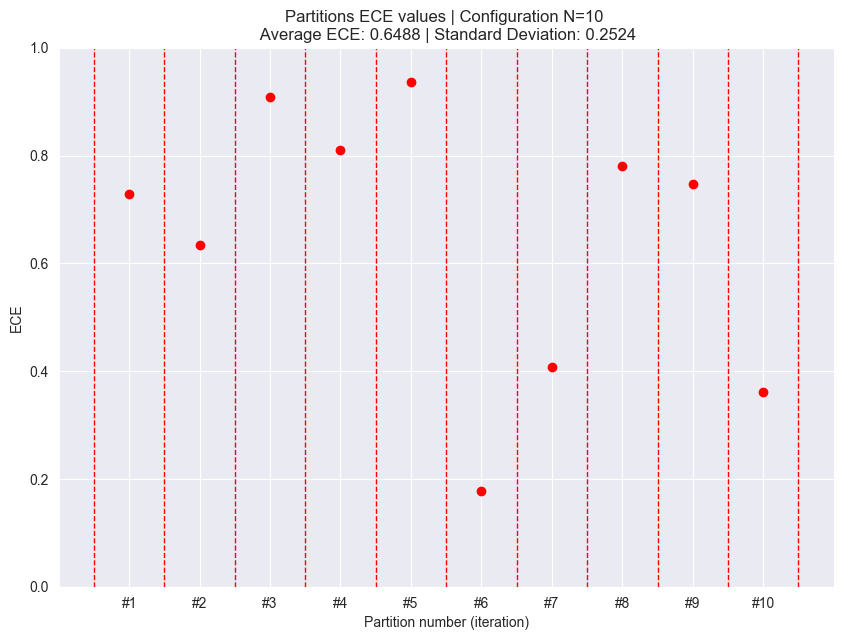

In [85]:
# Running the tests for the configuration with N = 10
results, results_per_iteration = run_tests(10)
results_data_frame = pd.DataFrame.from_dict(results)
results_per_iteration_data_frame = pd.DataFrame(results_per_iteration, index=["ECE"])

In [86]:
# Printing the tests for the configuration with N = 10
print(f"Results for configuration N=10")
results_data_frame

Results for configuration N=10


,N=10
Elapsed time,23.531909
Average ECE,0.648800
Standard Deviation,0.252400


In [87]:
# Printing results per iteration for the configuration with N = 10
print("Results Per Iteration for configuration N=10")
pd.DataFrame.transpose(results_per_iteration_data_frame)

Results Per Iteration for configuration N=10


,ECE
Iteration #1,0.7279
Iteration #2,0.6347
Iteration #3,0.9086
Iteration #4,0.8100
Iteration #5,0.9355
Iteration #6,0.1767
Iteration #7,0.4072
Iteration #8,0.7797
Iteration #9,0.7478
Iteration #10,0.3604


### Testing N = 100

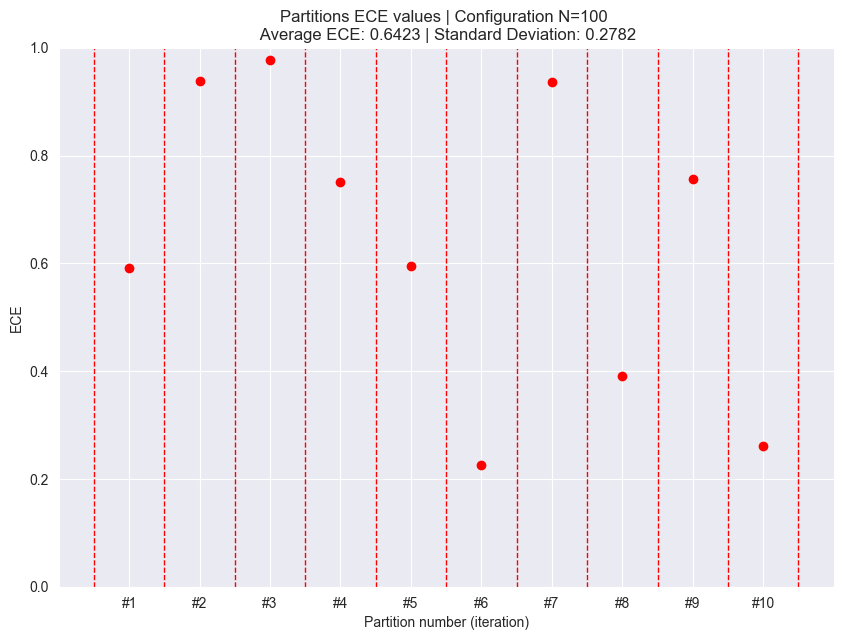

In [88]:
# Running the tests for the configuration with N = 100
results, results_per_iteration = run_tests(100)
results_data_frame = pd.DataFrame.from_dict(results)
results_per_iteration_data_frame = pd.DataFrame(results_per_iteration, index=["ECE"])

In [89]:
# Printing the tests for the configuration with N = 100
print(f"Results for configuration N=100")
results_data_frame

Results for configuration N=100


,N=100
Elapsed time,25.592349
Average ECE,0.642300
Standard Deviation,0.278200


In [90]:
# Printing results per iteration for the configuration with N = 100
print("Results Per Iteration for configuration N=100")
pd.DataFrame.transpose(results_per_iteration_data_frame)

Results Per Iteration for configuration N=100


,ECE
Iteration #1,0.5913
Iteration #2,0.9384
Iteration #3,0.9771
Iteration #4,0.7512
Iteration #5,0.5942
Iteration #6,0.2265
Iteration #7,0.9356
Iteration #8,0.3918
Iteration #9,0.7560
Iteration #10,0.2611


### Testing N = 1000

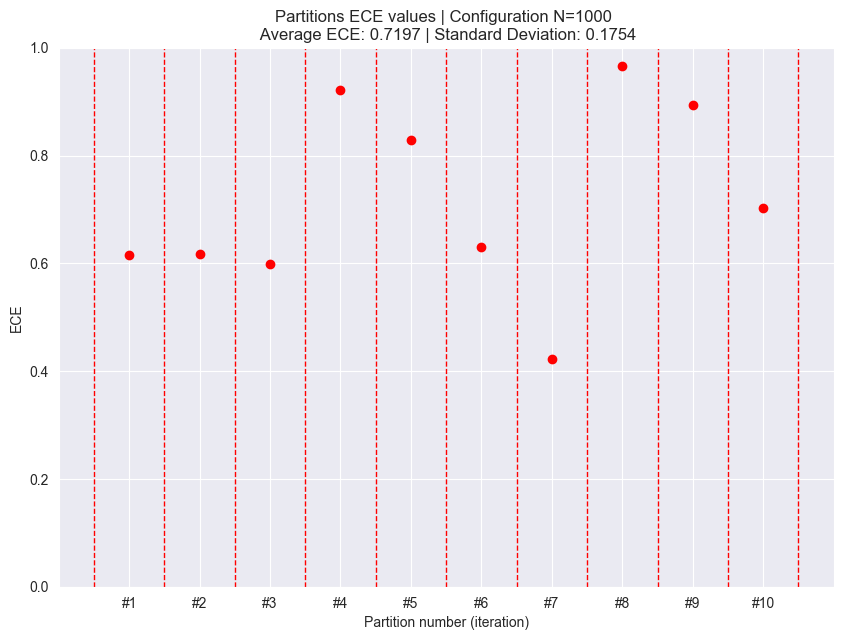

In [91]:
# Running the tests for the configuration with N = 1000
results, results_per_iteration = run_tests(1000)
results_data_frame = pd.DataFrame.from_dict(results)
results_per_iteration_data_frame = pd.DataFrame(results_per_iteration, index=["ECE"])

In [92]:
# Printing the tests for the configuration with N = 1000
print(f"Results for configuration N=1000")
results_data_frame

Results for configuration N=1000


,N=1000
Elapsed time,34.572599
Average ECE,0.719700
Standard Deviation,0.175400


In [93]:
# Printing results per iteration for the configuration with N = 1000
print("Results Per Iteration for configuration N=1000")
pd.DataFrame.transpose(results_per_iteration_data_frame)

Results Per Iteration for configuration N=1000


,ECE
Iteration #1,0.6150
Iteration #2,0.6174
Iteration #3,0.5985
Iteration #4,0.9217
Iteration #5,0.8296
Iteration #6,0.6310
Iteration #7,0.4216
Iteration #8,0.9661
Iteration #9,0.8937
Iteration #10,0.7028
